In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import h5py
import cv2  # For Gaussian filter


In [3]:
# Function to apply a Gaussian filter for denoising
def apply_gaussian_filter(images):
    """Applies a Gaussian filter to denoise the input images."""
    denoised_images = []
    for image in images:
        # Convert to uint8 for cv2 to process
        image_uint8 = (image * 255).astype(np.uint8)
        # Apply Gaussian filter
        denoised_image = cv2.GaussianBlur(image_uint8, (5, 5), sigmaX=1)
        # Normalize back to [0, 1]
        denoised_images.append(denoised_image / 255.0)
    return np.array(denoised_images)


In [4]:
# Residual Dense Block with Attention
def residual_dense_block(input_tensor, filters):
    """Residual Dense Block as described in the RDN paper with attention."""
    x = input_tensor
    for _ in range(4):
        x = layers.Conv2D(filters, (3, 3), padding="same")(x)
        x = layers.LeakyReLU(0.2)(x)
        input_tensor = layers.Concatenate()([input_tensor, x])
    
    # Channel Attention
    channel_attention = layers.GlobalAveragePooling2D()(x)
    channel_attention = layers.Dense(filters // 16, activation='relu')(channel_attention)
    channel_attention = layers.Dense(filters, activation='sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, 1, filters))(channel_attention)
    x = layers.multiply([x, channel_attention])  # Apply attention
    return x


In [5]:
# Generator Model
def build_rdn_generator(input_shape):
    """Residual Dense Network (RDN) Generator with Attention."""
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(64, (3, 3), padding="same")(inputs)
    
    # Residual Dense Blocks with Attention
    for _ in range(6):  # 6 RDN blocks
        x = residual_dense_block(x, 64)
    
    # Upsample layers
    x = layers.Conv2D(256, (3, 3), padding="same")(x)
    x = layers.UpSampling2D(size=2)(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(3, (3, 3), padding="same", activation="tanh")(x)

    return Model(inputs, x)


In [6]:
def build_discriminator(input_shape, identity_feature_shape):
    input_img = layers.Input(shape=input_shape)  # High-resolution input
    input_lr = layers.Input(shape=input_shape)   # Low-resolution input
    identity_features = layers.Input(shape=identity_feature_shape)  # Identity features (e.g., 4, 4, 512)
    
    # Resize identity features to match input shape
    resized_identity_features = layers.Reshape((input_shape[0], input_shape[1], -1))(identity_features)
    print(f"Shape of resized identity features: {resized_identity_features.shape}")
    
    # Concatenate inputs: high-resolution image, low-resolution image, and identity features
    concatenated = layers.Concatenate()([input_img, input_lr, resized_identity_features])
    print(f"Shape after concatenation: {concatenated.shape}")
    
    # Convolutional layers
    x = layers.Conv2D(64, (3, 3), padding="same")(concatenated)
    x = layers.LeakyReLU(0.2)(x)
    print(f"Shape after first Conv2D: {x.shape}")
    
    for i in range(4):
        x = layers.Conv2D(64 * (2 ** i), (3, 3), strides=2, padding="same")(x)
        x = layers.LeakyReLU(0.2)(x)
        print(f"Shape after Conv2D layer {i+1}: {x.shape}")
        
    output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
    print(f"Shape of final output: {output.shape}")
    
    return Model([input_img, input_lr, identity_features], output)


In [ ]:
# Identity Model
def build_identity_model(input_shape):
    """Pre-trained face recognition model to extract identity features"""
    base_model = VGG19(include_top=False, input_shape=input_shape)
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer("block5_conv4").output)
    return feature_extractor


In [8]:
# Perceptual loss function
def perceptual_loss(hr_image, sr_image, identity_model):
    """Perceptual loss based on the identity features."""
    # Ensure images are properly sized before passing to the identity model
    hr_features = identity_model(hr_image, training=False)  # Pass HR image to identity model
    sr_features = identity_model(sr_image, training=False)  # Pass SR image to identity model
    return tf.reduce_mean(tf.square(hr_features - sr_features))

# Pixel-wise loss function
def pixel_mse_loss(hr_image, sr_image):
    """Pixel-wise Mean Squared Error (MSE) Loss"""
    return tf.reduce_mean(tf.square(hr_image - sr_image))

# Adversarial loss function
def adversarial_loss(disc_real, disc_fake):
    """Hinge Version of Adversarial Loss"""
    return tf.reduce_mean(tf.nn.relu(1.0 - disc_real)) + tf.reduce_mean(tf.nn.relu(1.0 + disc_fake))


In [9]:
# Data preparation function
def prepare_data(batch_size=16, image_size=(32, 32), identity_size=(128, 128)):
    """Prepare data from the LFW dataset."""
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    # Create a generator for high-resolution images
    hr_data = datagen.flow_from_directory(
        r"D:\IMAGES",  # Update this path to your LFW dataset location
        target_size=image_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=True
    )
    
    while True:
        hr_images = hr_data.next()  # Get next batch of HR images
        lr_images = hr_data.next()  

        # Denoise HR images before resizing for the identity model
        hr_images_denoised = apply_gaussian_filter(hr_images)

        yield lr_images, hr_images_denoised  # Yield both LR and resized HR images
    return lr_images, hr_images_denoised

In [10]:
# Training procedure
def train_spgan(generator_model, discriminator, identity_model, train_data, epochs=10, steps_per_epoch=25):
    gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        for step in range(steps_per_epoch):
            try:
                # Get the next batch of low-resolution and high-resolution images
                lr_images, hr_images = next(train_data)  # Ensure this yields correctly shaped batches

                # Check if the batch size is less than 5
                if lr_images.shape[0] < 5 or hr_images.shape[0] < 5:
                    
                    continue  # Skip the rest of the loop and proceed to the next batch

                lr_img = tf.image.resize(hr_images, (16, 16))  # Resize for LR

                # Generate super-resolution images using the low-resolution input
                sr_images = generator_model(lr_img, training=True)

                # Upsample identity features if necessary
                hr_identity_features_resized = tf.image.resize(identity_model(hr_images), (128, 128))
                sr_identity_features_resized = tf.image.resize(identity_model(sr_images), (128, 128))

                # Train the discriminator
                with tf.GradientTape() as disc_tape:
                    real_output = discriminator([hr_images, lr_images, hr_identity_features_resized])  
                    fake_output = discriminator([sr_images, lr_images, sr_identity_features_resized])  

                    disc_loss = adversarial_loss(real_output, fake_output)

                disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
                disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

                # Train the generator
                with tf.GradientTape() as gen_tape:
                    sr_images = generator_model(lr_img, training=True)  
                    
                    # Calculate perceptual and pixel-wise losses
                    perc_loss = perceptual_loss(hr_images, sr_images, identity_model)
                    pixel_loss = pixel_mse_loss(hr_images, sr_images)  

                    # Generator loss includes perceptual loss and pixel-wise loss
                    gen_loss = perc_loss + pixel_loss - tf.reduce_mean(fake_output)

                gen_gradients = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
                gen_optimizer.apply_gradients(zip(gen_gradients, generator_model.trainable_variables))

            except StopIteration:
                print("Data iterator has been exhausted.")
                break

        print(f" - Generator Loss: {gen_loss.numpy()} - Discriminator Loss: {disc_loss.numpy()}")


In [11]:
# Instantiate models
input_shape = (16, 16, 3)  # LR image shape
identity_feature_shape = (128, 128, 512)  # Identity feature shape after VGG19

generator = build_rdn_generator(input_shape)
discriminator = build_discriminator((32, 32, 3), identity_feature_shape)
identity_model = build_identity_model((32, 32, 3))  # Pre-trained model expects 128x128




Shape of resized identity features: (None, 32, 32, 8192)
Shape after concatenation: (None, 32, 32, 8198)
Shape after first Conv2D: (None, 32, 32, 64)
Shape after Conv2D layer 1: (None, 16, 16, 64)
Shape after Conv2D layer 2: (None, 8, 8, 128)
Shape after Conv2D layer 3: (None, 4, 4, 256)
Shape after Conv2D layer 4: (None, 2, 2, 512)
Shape of final output: (None, 2, 2, 1)


In [12]:
# Prepare the training data
train_data = prepare_data(batch_size=5, image_size=(32, 32))

# Train the SPGAN
train_spgan(generator, discriminator, identity_model, train_data, epochs=10, steps_per_epoch=15)

Epoch 1/10
Found 156 images belonging to 80 classes.
 - Generator Loss: -0.866277813911438 - Discriminator Loss: 1.9947798252105713
Epoch 2/10
 - Generator Loss: 0.15802523493766785 - Discriminator Loss: 1.0000699758529663
Epoch 3/10
 - Generator Loss: 0.11985572427511215 - Discriminator Loss: 1.0000642538070679
Epoch 4/10
 - Generator Loss: -0.2793430685997009 - Discriminator Loss: 1.3995907306671143
Epoch 5/10
 - Generator Loss: 0.08553507924079895 - Discriminator Loss: 1.0
Epoch 6/10
 - Generator Loss: -0.719698965549469 - Discriminator Loss: 1.7989885807037354
Epoch 7/10
 - Generator Loss: 0.060056254267692566 - Discriminator Loss: 1.002118468284607
Epoch 8/10
 - Generator Loss: 0.041819017380476 - Discriminator Loss: 1.7999999523162842
Epoch 9/10
 - Generator Loss: -0.9421983361244202 - Discriminator Loss: 2.0
Epoch 10/10
 - Generator Loss: -0.7372923493385315 - Discriminator Loss: 1.8000061511993408


In [19]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def face_recognition_accuracy(generator, identity_model, test_data, threshold=0.5, num_batches=100):
    correct = 0
    total = 0
    
    # Start tracking time
    start_time = time.time()

    for batch in range(num_batches):
        lr_images, hr_images = next(test_data)  # Use next to get the batch
        
        # Check if the batch size is less than 5
        if lr_images.shape[0] < 5 or hr_images.shape[0] < 5:
            continue
        
        lr_img = tf.image.resize(lr_images, (16, 16)) 
        # Generate super-resolved images
        sr_images = generator.predict(lr_img)
        
        # Extract identity features from HR and SR images
        hr_identity_features = identity_model.predict(hr_images)
        sr_identity_features = identity_model.predict(sr_images)
        
        # Calculate cosine similarity
        similarity_scores = cosine_similarity(
            hr_identity_features.reshape(len(hr_images), -1),
            sr_identity_features.reshape(len(sr_images), -1)
        )
        
        # Count correct predictions
        for score in similarity_scores:
            # Check if any score in the row is above the threshold
            if np.any(score >= threshold):
                correct += 1
                
        total += len(hr_images)

        # Print progress every 10 batches
        if batch % 10 == 0:
            elapsed_time = time.time() - start_time
            estimated_time = (elapsed_time / (batch + 1)) * (num_batches - (batch + 1))
            print(f"Processed {total} images, estimated time remaining: {estimated_time:.2f} seconds")

        # Show last 5 images from the batch
        if batch % 5 == 0:  # Display every 5 batches
            show_last_images(lr_images, hr_images, sr_images)

    accuracy = correct / total if total > 0 else 0  # Avoid division by zero
    print(f"Face Recognition Accuracy: {accuracy * 100:.2f}%")
    return accuracy

def show_last_images(lr_images, hr_images, sr_images):
    """Displays the last 5 images from low-resolution, high-resolution, and super-resolved images for the same sample."""
    indices = range(sr_images.shape[0] - 5, sr_images.shape[0])  # Select the last 5 indices
    plt.figure(figsize=(15, 5))  # Adjust the figure size for better visibility
    
    for i, idx in enumerate(indices):
        # Display Low-Res, High-Res, and Super-Res Image (LR, HR, SR) for the same image
        plt.subplot(3, 5, i + 1)
        plt.imshow(lr_images[idx])
        plt.title('Low-Res Image')
        plt.axis('off')

        plt.subplot(3, 5, i + 6)
        plt.imshow(hr_images[idx])
        plt.title('High-Res Image')
        plt.axis('off')

        plt.subplot(3, 5, i + 11)
        plt.imshow(sr_images[idx])
        plt.title('Super-Res Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Found 156 images belonging to 80 classes.
Processed 5 images, estimated time remaining: 462.41 seconds


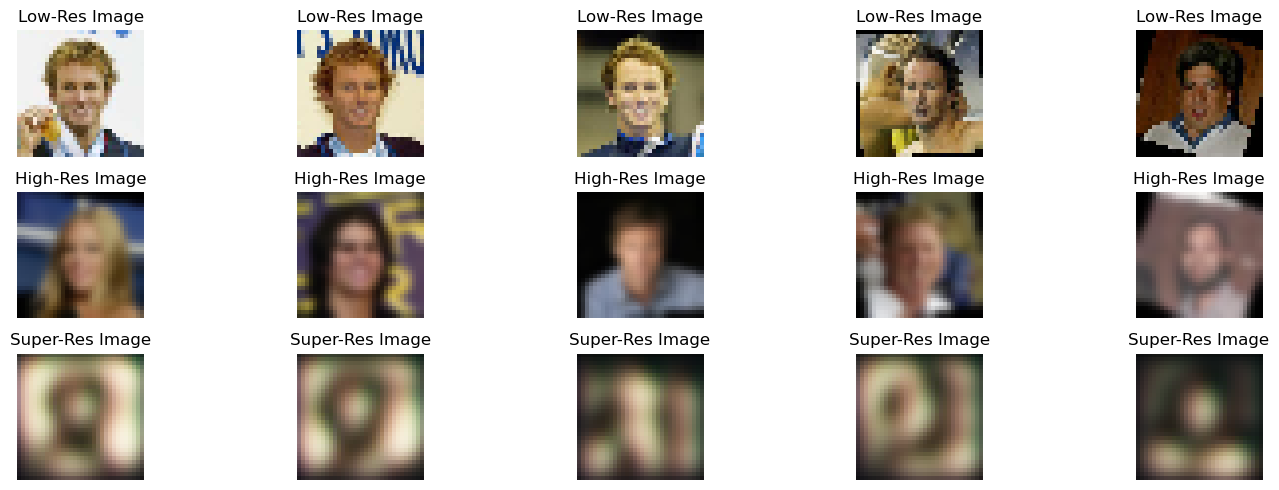

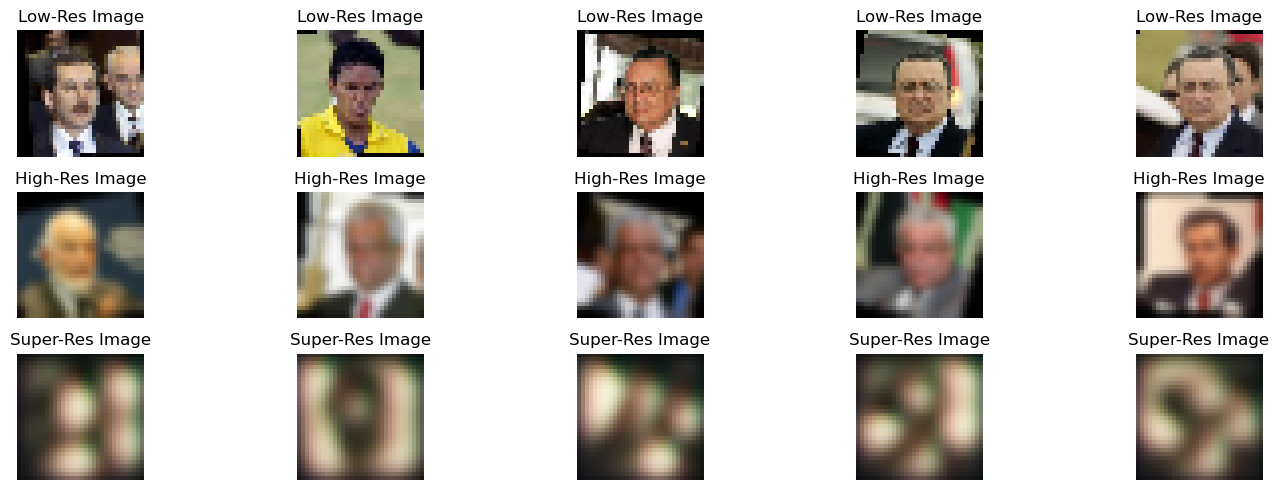

Processed 55 images, estimated time remaining: 101.15 seconds


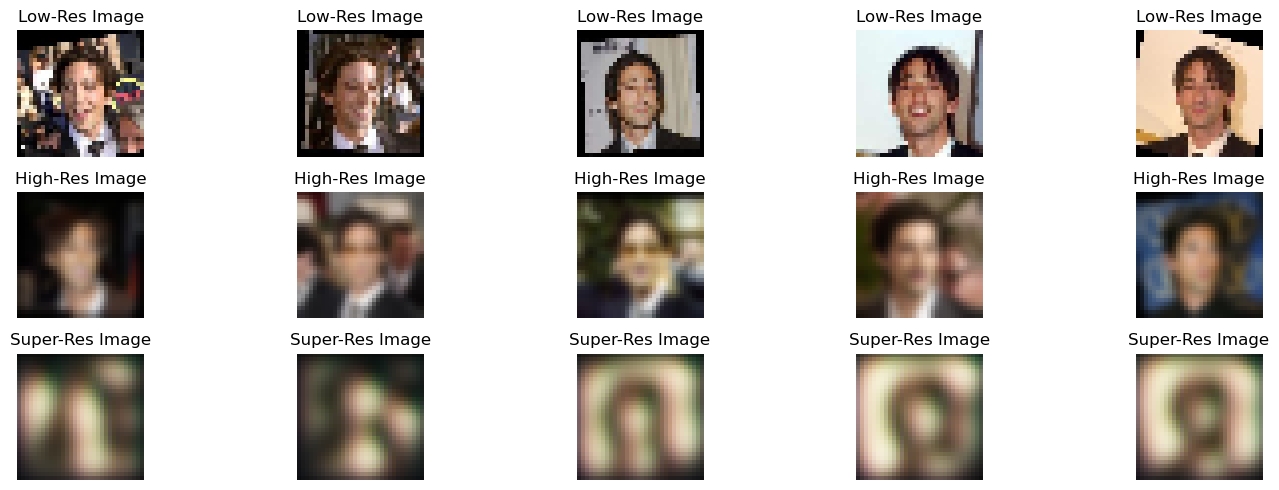

Processed 100 images, estimated time remaining: 67.23 seconds


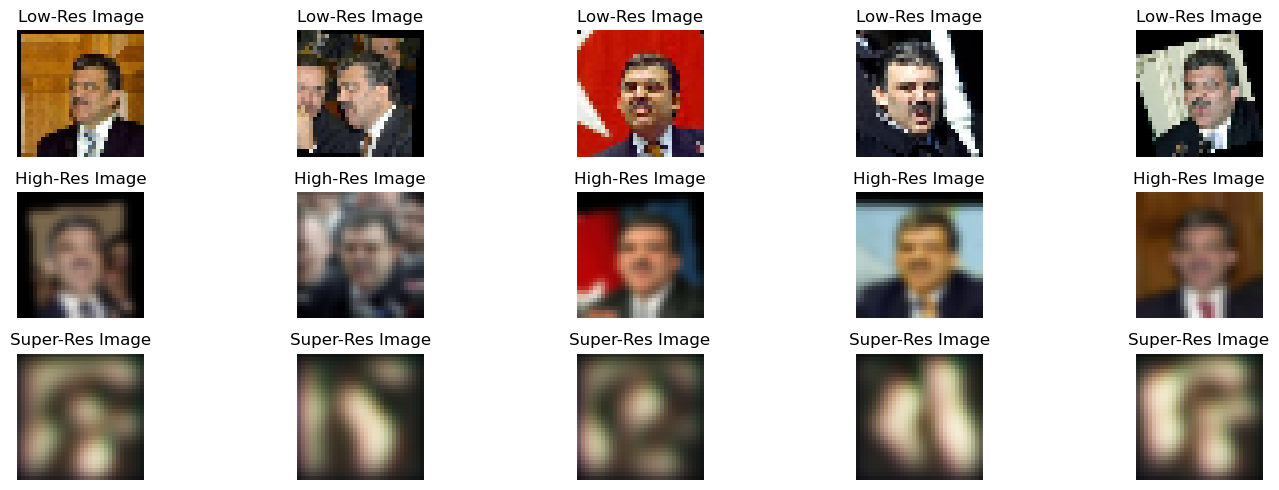

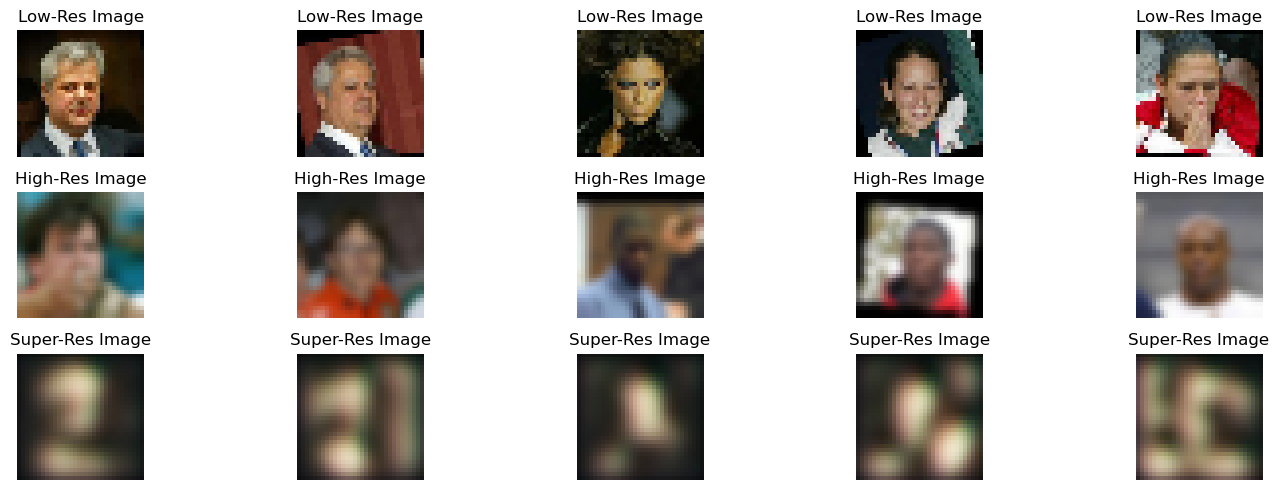

Processed 150 images, estimated time remaining: 51.91 seconds


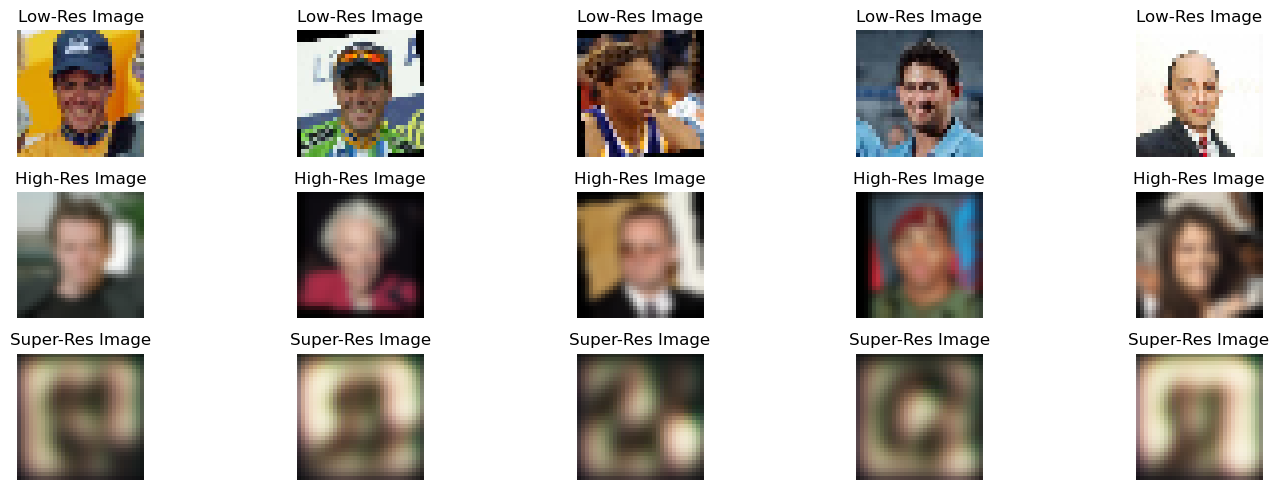

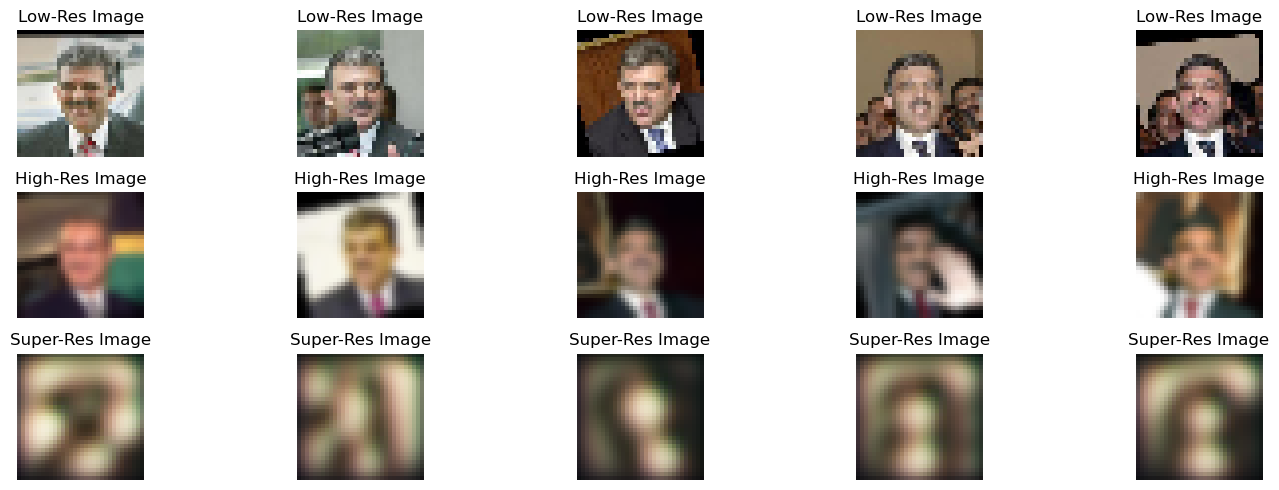

Processed 195 images, estimated time remaining: 44.47 seconds


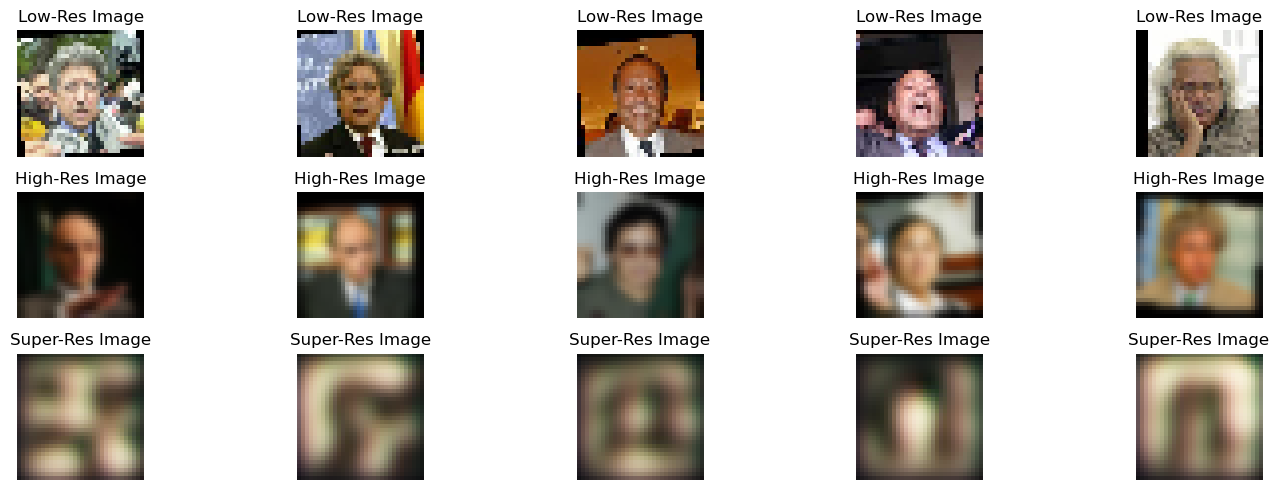

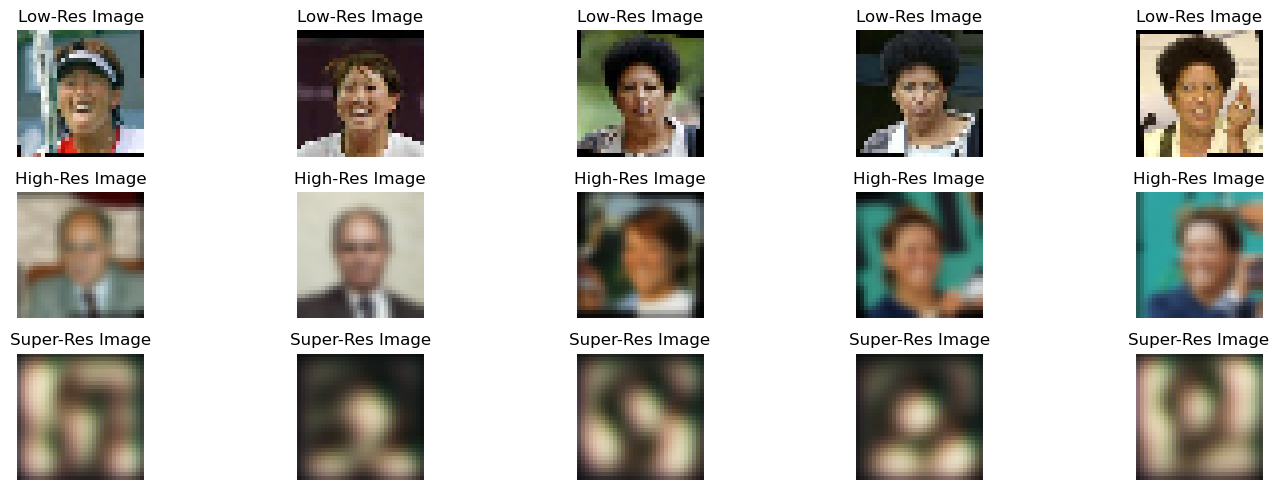

Processed 240 images, estimated time remaining: 35.52 seconds


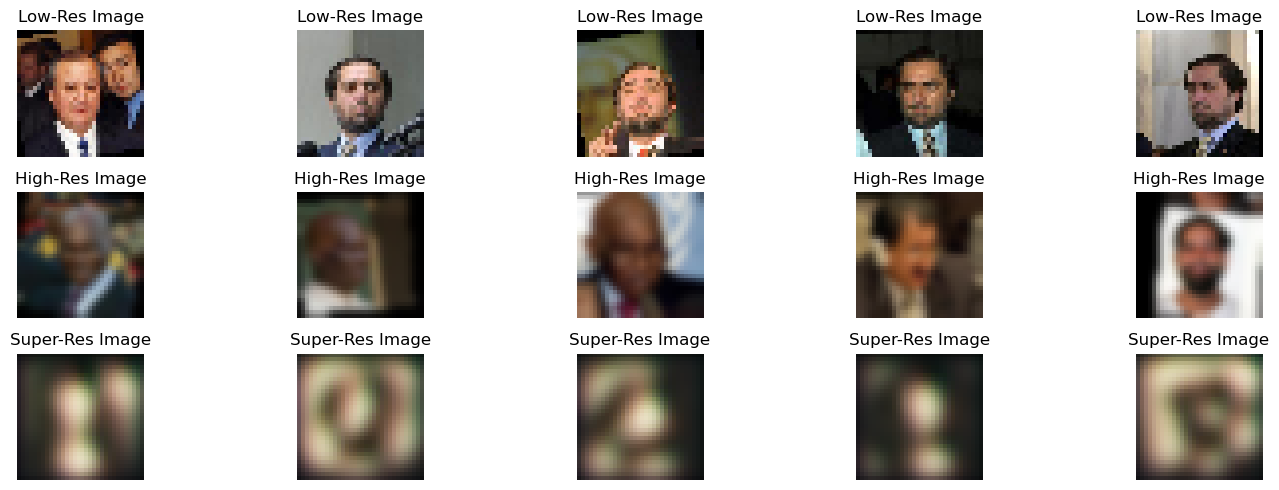

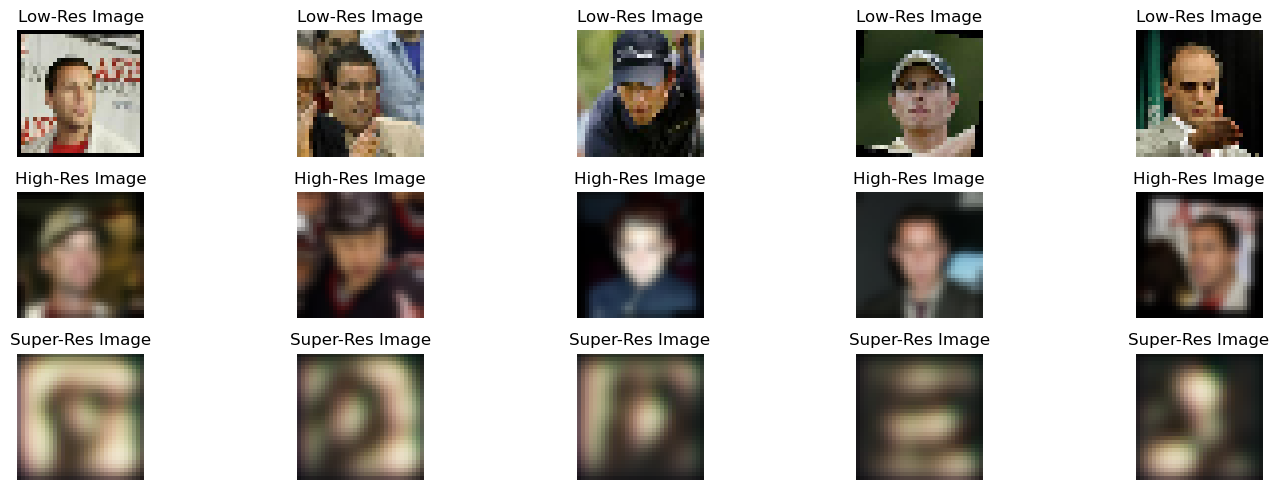

Processed 290 images, estimated time remaining: 27.20 seconds


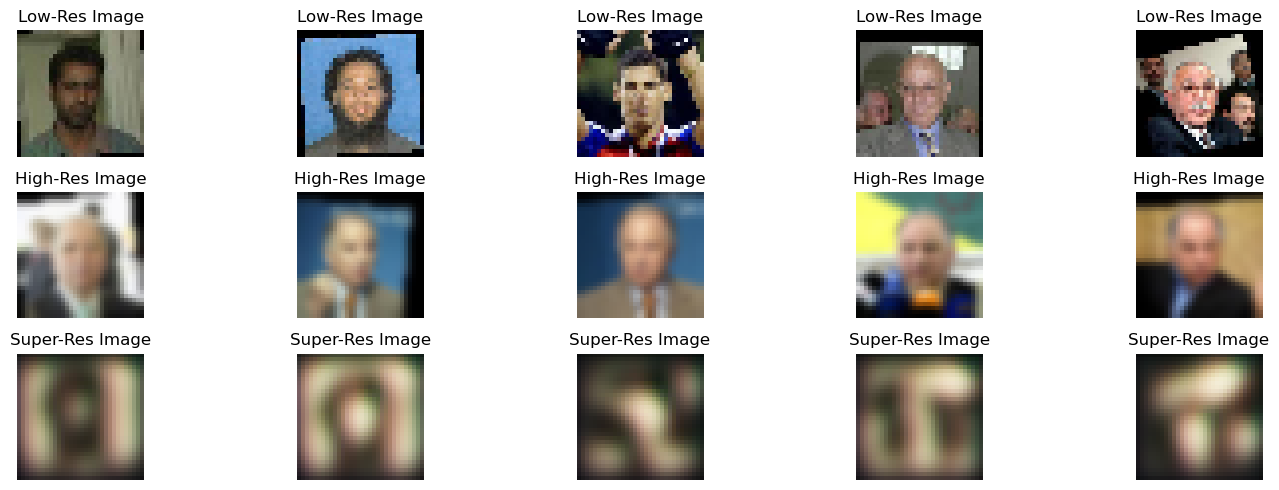

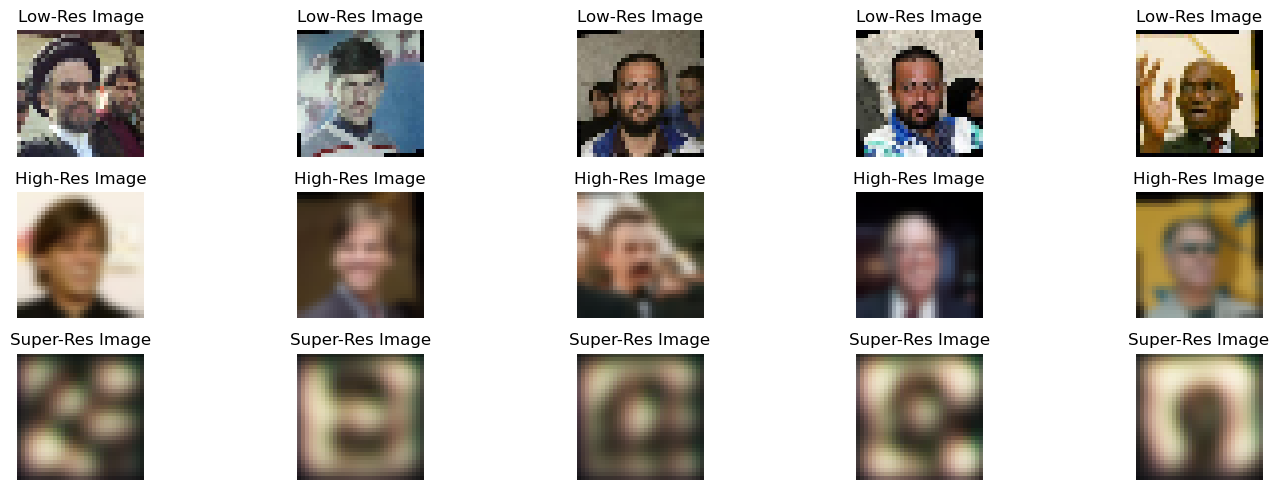

Processed 335 images, estimated time remaining: 19.69 seconds


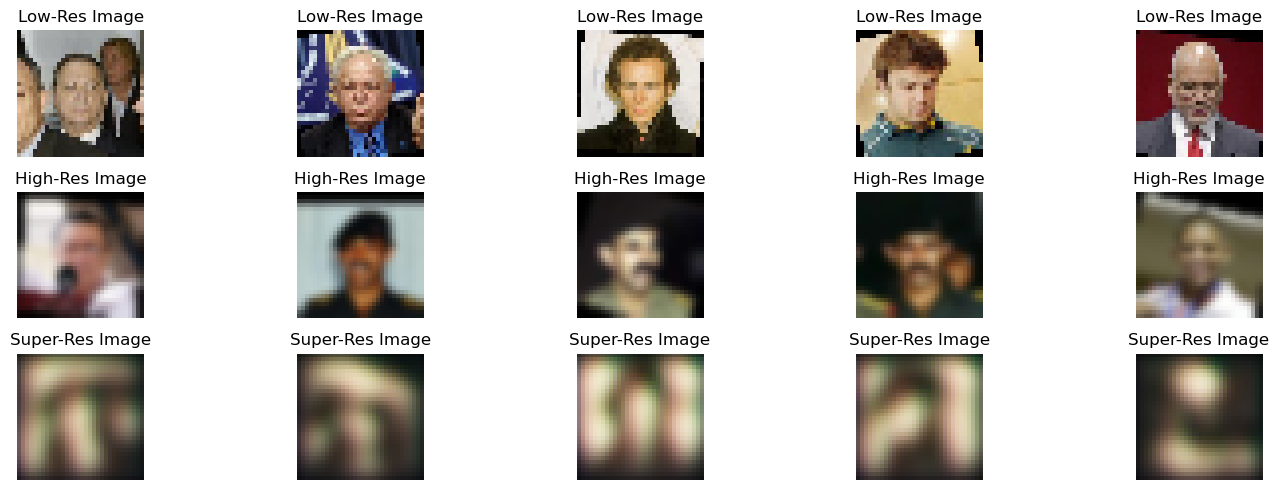

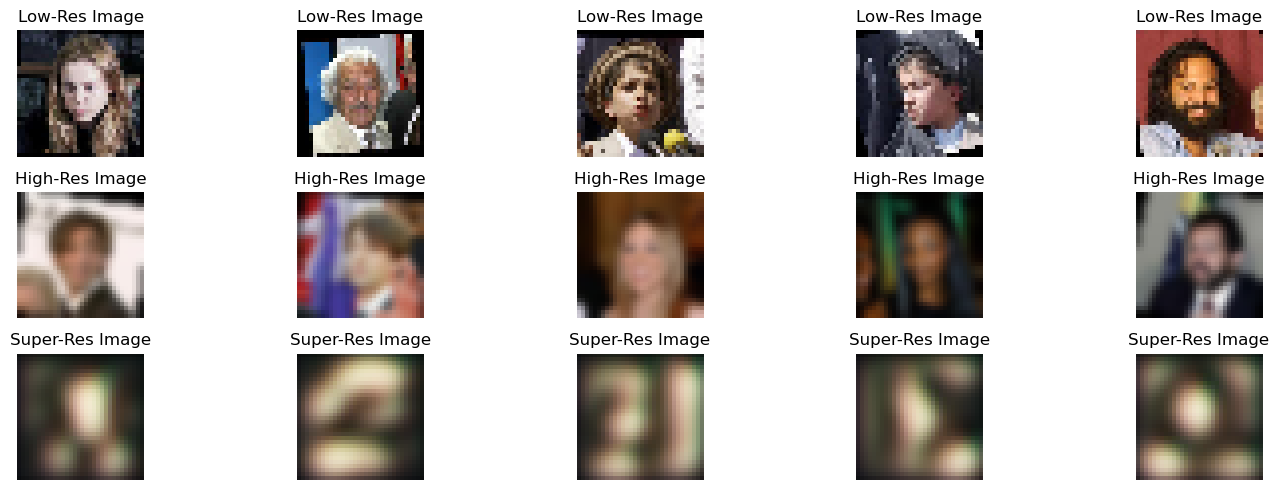

Processed 380 images, estimated time remaining: 12.52 seconds


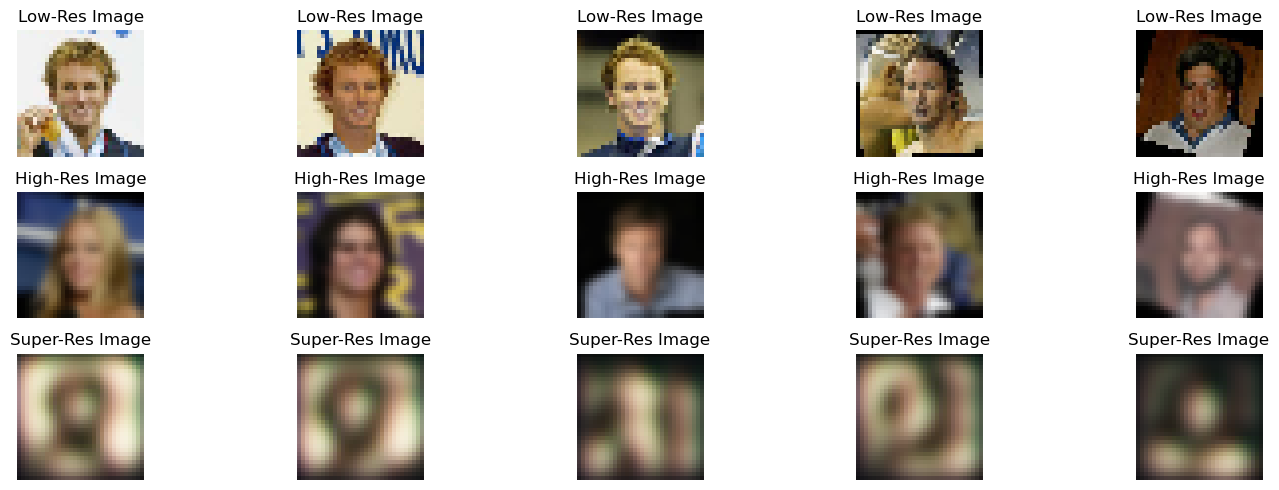

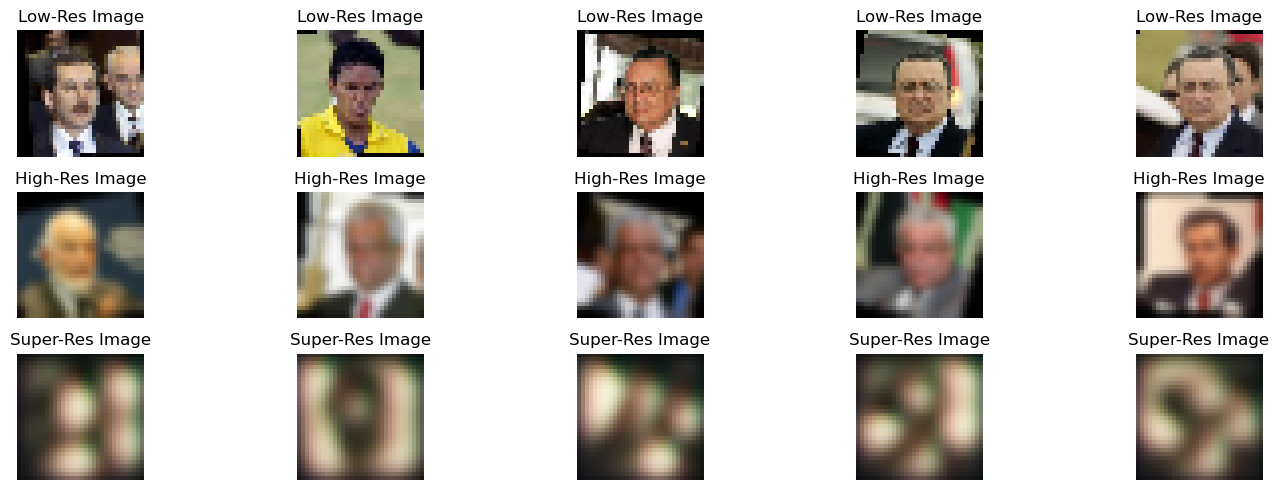

Processed 430 images, estimated time remaining: 5.86 seconds


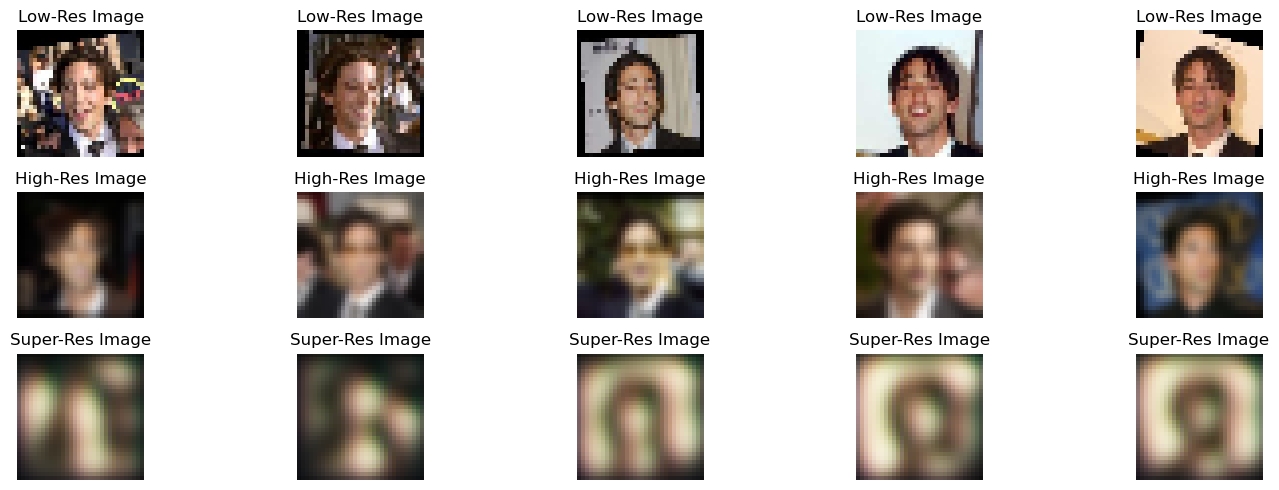

Face Recognition Accuracy: 100.00%


1.0

In [20]:
# Prepare test data (this can be part of the training dataset or separate test data)
test_data = prepare_data(batch_size=5, image_size=(32, 32))

# Evaluate the face recognition accuracy
face_recognition_accuracy(generator, identity_model, test_data, threshold=0.5, num_batches=100)